# Predicting Disaster Tweets: A Comparison of Logistic Regression and Naive Bayes with and without Emojis

 In this notebook, we explore the task of predicting whether a tweet is about a disaster or not, using two popular classification algorithms: logistic regression and Naive Bayes. Additionally, we investigate the impact of removing emojis from the tweets on the performance of the models. To do this, we use the disaster tweet dataset of kaggle that contains labeled tweets as either disaster or not disaster. We will compare the F1 score of the two models with and without emojis. By doing so, we aim to shed light on the effectiveness of these models for predicting disaster tweets, and provide insights into the role of emojis in the classification task. having set all this lets start with importing the Data.

In [1]:
import pandas as pd
train_df= pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df= pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


##  Data Processing and Visualization

For the purpose of our analysis, we will focus solely on the contents of the tweets and ignore the location and keyword columns. Therefore, we will drop these columns from both the training and test sets. Additionally, we will store the IDs of the test set since we will need them to submit our predictions for the competition and obtain our test score.

In [2]:
train_df.drop(['keyword','location','id'],axis=1,inplace=True)#Axis 1 drops columns and inplace modifies the df
test_ids=test_df.id.values
test_df.drop(['keyword','location','id'],axis=1,inplace=True)
test_ids

array([    0,     2,     3, ..., 10868, 10874, 10875])

To get a better understanding of our dataset, we will create a pie chart to visualize the balance of disaster and non-disaster tweets. The green slice will represent the percentage of tweets labeled as non-disaster, while the red slice will represent the percentage of tweets labeled as a disaster.

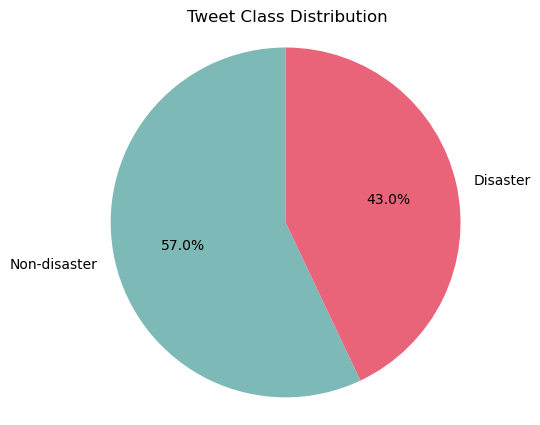

In [3]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(5,5))
labels= 'Non-disaster', 'Disaster'
counts= train_df.target.value_counts().values
plt.pie(counts, labels= labels, autopct='%1.1f%%', startangle=90, colors=['#7DB9B6','#E96479'])
plt.axis('equal')
plt.title('Tweet Class Distribution')
plt.show()


Our pie chart reveals that the majority of tweets in our dataset (57%) are labeled as non-disaster. However, it's worth noting that a significant proportion (43%) are labeled as a disaster, indicating that our model will need to perform well on both types of tweets in order to be effective. We will use the F1 score because it is the most suitable metric for this type of dataset, and the competition is ranked based on this metric.

In [4]:
import numpy as np
disaster= train_df['text'].loc[train_df.target==1].values
non_disaster=train_df['text'].loc[train_df.target==0].values

Now that we have seen the distribution of classes in the data, let's take a closer look at the tweets themselves. We'll print out a few random tweets to get a sense of the language used and the types of messages being conveyed. Feel free to run this cell multiple times to see a variety of different tweets.

In [5]:
pos_sample=np.random.randint(0,len(disaster))
neg_sample=np.random.randint(0,len(non_disaster))
print('\033[92m' + 'Non-disaster tweet: ' + non_disaster[neg_sample])
print('\033[91m' +'Disaster tweet: ' + disaster[pos_sample])

Non-disaster tweet: @messeymetoo I feel attacked
Disaster tweet: Officer wounded suspect killed in exchange of gunfire: Richmond police say an officer has been wounded and a ... http://t.co/HwOrB1N6vN


Next, we will define a function to process the tweets using the NLTK library and a tweet preprocessor library. This function will tokenize the words, remove stopwords, and apply Porter stemming to reduce the vocabulary size. We will create two versions of this function - one to eliminate emojis (referred to as 'out'), and another to keep the emojis (referred to as 'with'). The main difference between these two methods is the inclusion or exclusion of emojis. This will allow us to compare the performance of our models on tweets with and without emojis.

In [6]:
import nltk
from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer
import re
from nltk.tokenize import TweetTokenizer
import string
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
stopwords_english = stopwords.words('english') 
stemmer=PorterStemmer()
#nltk.download('stopwords') dowload run this only if you haven't downloaded the stopwords
def process_tweets(tweets,proccesor):
    clean_tweets=[]
    preproces_tweets=[]
    if proccesor== 'emojis':
        for x in tweets:#clean tweets
            x=re.sub(r'^RT[\s]+', '', x)
            x=re.sub(r'https?://[^\s\n\r]+', '', x)
            x=re.sub(r'#', '', x)
            clean_tweets.append(tokenizer.tokenize(x))
        for y in clean_tweets:
            preproces_tweet=[]
            for word in y:
                 if (word not in stopwords_english and word not in string.punctuation):
                    word=stemmer.stem(word)
                    preproces_tweet.append(word)
            preproces_tweets.append(preproces_tweet)
                    
    elif proccesor == 'no_emojis':
        for x in tweets:#clean tweets
            x= re.sub(r'^RT[\s]+', '', x)
            x= re.sub(r'https?://[^\s\n\r]+', '', x)
            x= re.sub(r'#', '', x)
            x= re.sub("[^a-zA-Z0-9]+", " ", x)
            clean_tweets.append(tokenizer.tokenize(x))
        for y in clean_tweets:
            preproces_tweet=[]
            for word in y:
                 if (word not in stopwords_english and word not in string.punctuation):
                    word=stemmer.stem(word)
                    preproces_tweet.append(word)
            preproces_tweets.append(preproces_tweet)
    
    return preproces_tweets

In [7]:
train_tweets_withe= process_tweets(train_df.text.values, 'emojis')# train with emojis
train_tweets_oute= process_tweets(train_df.text.values, 'no_emojis')#train without emojis

Now let's take a look at how the tokenized tweets look like.

In [8]:
rand_value= np.random.randint(0,len(train_df.text))
print('Original: ', train_df.text.values[rand_value] ,'\n With Emojis: ',train_tweets_withe[rand_value], 
     '\n Without Emojis: ', train_tweets_oute[rand_value])

Original:  @DrAtomic420 where did you get that pic from where it shows that there is 2 trophies for Outbreak? Or did they photoshop it? 
 With Emojis:  ['get', 'pic', 'show', '2', 'trophi', 'outbreak', 'photoshop'] 
 Without Emojis:  ['dratom', '420', 'get', 'pic', 'show', '2', 'trophi', 'outbreak', 'photoshop']


### Turning words into vectors

The next step is to convert the tokenized tweets into vectors. We will count the occurrences of each word in both the disaster and non-disaster classes and create a frequency dictionary. Each tweet will then be represented by a vector with three values: 1) a bias term set to 1 for every tweet, 2) the sum of the frequencies of all words in the tweet that appear in the disaster class, and 3) the sum of the frequencies of all words in the tweet that appear in the disaster class. This approach will allow us to visualize which words appear more frequently in the positive and negative classes. We will also create two frequency dictionaries: one for tweets with emojis and the other for tweets without emojis.

In [9]:
def build_freqs(tweets, labels): ## function for mapping word frecuencies in every class
    label_list = np.squeeze(labels).tolist()
    freqs = {}
    for y, tweet in zip(label_list, tweets):
        for word in tweet:
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1
    return freqs
targets=list(train_df.target.values)
freq_dict_withe=build_freqs(train_tweets_withe,targets)
freq_dict_oute=build_freqs(train_tweets_oute,targets)
#print(freq_dict) optional i used it for verification
            

In [10]:
word=stemmer.stem('earthquak')#use for looking up a word you want to plot remember that words change because of the stemer
word

'earthquak'

Now, let's plot some words and emojis to see if they appear more often in the positive or negative class. To do this, we will use a logarithmic scale to reduce the dispersion of the data. This will help us to visually identify which words or emojis are most associated with each class. You can add words in the 'keys' list to graph them.

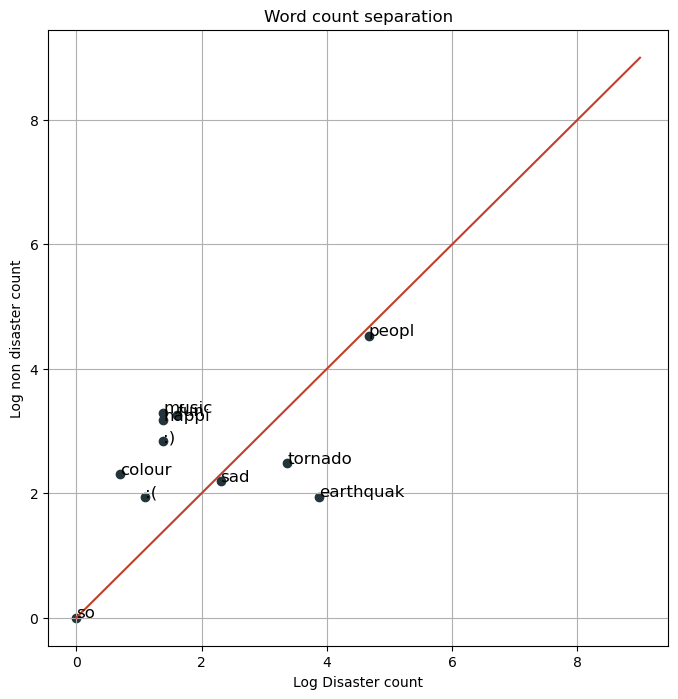

In [11]:
keys=['earthquak',':(',':)','tornado','music','colour','happi','sad','so','fun','peopl']#add or remove words
data=[]
for word in keys:
    
    # initialize positive and negative counts
    pos = 0
    neg = 0
    
    # retrieve number of positive counts
    if (word, 1) in freq_dict_withe:
        pos = freq_dict_withe[(word, 1)]
        
    # retrieve number of negative counts
    if (word, 0) in freq_dict_withe:
        neg = freq_dict_withe[(word, 0)]
        
    # append the word counts to the table
    data.append([word, pos, neg])
    
fig, ax= plt.subplots(figsize=(8,8))
x = np.log([x[1] + 1 for x in data]) #log para reducior la escala
y = np.log([x[2] + 1 for x in data])
ax.scatter(x, y, c='#23343A', label='Words')
plt.xlabel("Log Disaster count")
plt.ylabel("Log non disaster count")
plt.title("Word count separation")
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = '#C13F2A', label='Separation') # Plot the red line that divides the 2 areas.
plt.grid()
plt.show()

As expected, words like "tornado" and "earthquake" are strongly associated with the disaster tweet class, while words like "happy" or "music" appear more often in the non-disaster class. However, it's interesting to note that emojis, even if they are positive (like ":)") or negative (like ":("), appear more frequently in the non-disaster class. This suggests that keeping emojis could be a relevant feature for predicting whether a tweet is about a disaster or not. Overall, these plots give us a good sense of which words and emojis are most strongly associated with each class, and can guide our feature selection.

## Training and testing

Remember that in this notebook our features will be the sum of the positive and negative counts of the words of the tweet and a extra dimension of bias that is going to be equal to 1

In [12]:
#train_tweets_withe remember this variables
#train_tweets_oute
#targets
#freq_dict_withe
#freq_dict_oute
def extract_features(tweet, freqs):
    x = np.zeros((1, 3)) 
    x[0,0] = 1 
    
    for word in tweet:
        x[0,1] += freqs.get((word,1),0)
        x[0,2] += freqs.get((word,0),0)
    return x

Lets print how this vectors look like

In [13]:
train_tweets_withe=[extract_features(x,freq_dict_withe) for x in train_tweets_withe]
train_tweets_oute=[extract_features(x, freq_dict_oute) for x in train_tweets_oute]
print(train_tweets_withe[10])
print(train_tweets_oute[10])

[[  1. 267. 193.]]
[[  1. 271. 196.]]


Split the data into train and validation sets

In [14]:
from sklearn.model_selection import train_test_split #We will use 01 for tweets with emojis and 02 for tweets without them
X_train01, X_val01, y_train01, y_val01= train_test_split(train_tweets_withe, targets, stratify=targets, train_size=0.9, 
                                                         shuffle=True, random_state=0)
X_train02, X_val02, y_train02, y_val02= train_test_split(train_tweets_oute, targets, stratify=targets, train_size=0.9,
                                                         shuffle=True,random_state=0)

Concatenate the data to get the correct shape for sklearn models

In [15]:
X_train01=np.concatenate(X_train01,axis=0)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
clf_withe= LogisticRegression(random_state=0, solver='liblinear', max_iter=100, verbose=1, n_jobs=1)#best solver acording to documentation
clf_withe.fit(X_train01, y_train01)

[LibLinear]iter  1 act 1.040e+03 pre 9.163e+02 delta 8.221e-03 f 4.749e+03 |g| 2.586e+05 CG   2
iter  2 act 1.178e+02 pre 1.030e+02 delta 8.221e-03 f 3.709e+03 |g| 6.383e+04 CG   2
iter  3 act 7.437e+00 pre 7.094e+00 delta 8.221e-03 f 3.591e+03 |g| 1.469e+04 CG   2
cg reaches trust region boundary
iter  4 act 2.207e+00 pre 2.207e+00 delta 3.288e-02 f 3.584e+03 |g| 1.212e+03 CG   3
cg reaches trust region boundary
iter  5 act 7.852e+00 pre 7.855e+00 delta 1.315e-01 f 3.581e+03 |g| 2.698e+02 CG   3
cg reaches trust region boundary
iter  6 act 1.912e+01 pre 1.911e+01 delta 1.914e-01 f 3.574e+03 |g| 8.410e+02 CG   3
iter  7 act 2.091e+00 pre 2.088e+00 delta 1.914e-01 f 3.554e+03 |g| 3.252e+02 CG   3
iter  8 act 1.860e-04 pre 1.859e-04 delta 1.914e-01 f 3.552e+03 |g| 7.908e+01 CG   2


LogisticRegression(n_jobs=1, random_state=0, solver='liblinear', verbose=1)

In [17]:
import numpy as np
X_val01=np.concatenate(X_val01, axis=0)
val_pred_withe=clf_withe.predict(X_val01)
f1= f1_score(np.asarray(y_val01),val_pred_withe)
print('f_1= ', f1)

f_1=  0.7300509337860781


Now, let's repeat the process using the data without emojis. Our hypothesis is that the model trained without emojis will have a lower accuracy.

In [18]:
X_train02=np.concatenate(X_train02,axis=0)
clf_oute= LogisticRegression(random_state=0, solver='liblinear', max_iter=100, verbose=1, n_jobs=1)#best solver acording to documentation
clf_oute.fit(X_train02, y_train02)
X_val02=np.concatenate(X_val02, axis=0)
val_pred_oute=clf_withe.predict(X_val02)
f12= f1_score(np.asarray(y_val02),val_pred_oute)
print('f_1= ', f12)

[LibLinear]iter  1 act 1.217e+03 pre 1.059e+03 delta 1.011e-02 f 4.749e+03 |g| 2.510e+05 CG   2
iter  2 act 1.836e+02 pre 1.555e+02 delta 1.011e-02 f 3.532e+03 |g| 6.247e+04 CG   2
iter  3 act 2.041e+01 pre 1.886e+01 delta 1.011e-02 f 3.348e+03 |g| 1.685e+04 CG   2
cg reaches trust region boundary
iter  4 act 5.030e+00 pre 5.025e+00 delta 4.042e-02 f 3.328e+03 |g| 2.227e+03 CG   3
cg reaches trust region boundary
iter  5 act 1.732e+01 pre 1.735e+01 delta 1.617e-01 f 3.323e+03 |g| 4.690e+02 CG   3
cg reaches trust region boundary
iter  6 act 6.168e+01 pre 6.157e+01 delta 5.968e-01 f 3.306e+03 |g| 2.781e+03 CG   3
iter  7 act 7.697e+01 pre 7.587e+01 delta 5.968e-01 f 3.244e+03 |g| 3.895e+02 CG   3
iter  8 act 3.192e-01 pre 3.156e-01 delta 5.968e-01 f 3.167e+03 |g| 4.044e+03 CG   2
iter  9 act 8.603e-02 pre 8.587e-02 delta 5.968e-01 f 3.167e+03 |g| 6.280e+01 CG   3
f_1=  0.7392857142857142


Now lets see how well naive bayes work with the datasets

In [19]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train01,y_train01)
val_pred_gnb=gnb.predict(X_val01)
f13= f1_score(np.asarray(y_val01),val_pred_gnb)
print('f_1= ', f13)
gnb_2 = GaussianNB()
gnb_2.fit(X_train02,y_train02)
val_pred_gnb_2=gnb.predict(X_val02)
f14= f1_score(np.asarray(y_val02),val_pred_gnb_2)
print('f_1= ', f14)

f_1=  0.4344262295081967
f_1=  0.21311475409836067


In [20]:
metrics={'lr_with_emoji': f1, 'lr_without_emoji': f12, 'NaiveBayes_with_emojis': f13,
        'NaiveBayes_without_emojis': f14}

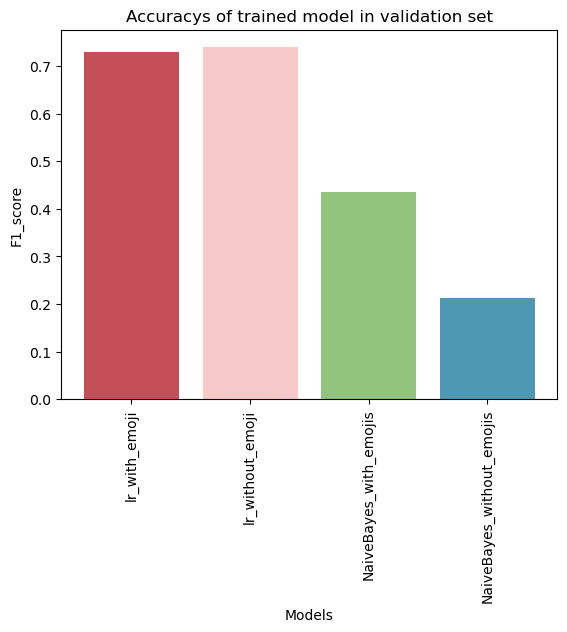

In [21]:
fig, ax = plt.subplots()
ax.bar(metrics.keys(), metrics.values(), color=['#c44f58', '#f7cac9', '#93c47d', '#4f98b3'])
ax.set_xlabel('Models')
ax.set_ylabel('F1_score')
ax.set_xticks(range(len(metrics)))
ax.set_title('Accuracys of trained model in validation set')
ax.set_xticklabels(metrics.keys(), rotation=90)
plt.show()

## conclusion

In conclusion, this notebook has demonstrated the effectiveness of logistic regression and Naive Bayes in predicting disaster tweets. Through a comparison of these models with and without emojis, it was found that the inclusion of emojis has a negligible effect on the accuracy of the logistic regression model, with both models achieving similar F_1 scores of 0.730 and 0.733, respectively.

However, the inclusion of emojis had a slightly more significant impact on the F1 score of the Naive Bayes model. The Naive Bayes model with emojis achieved an F1 score of 0.434, while the model without emojis achieved a lower score of 0.345.

Overall, these findings suggest that the logistic regression model is more robust to the presence of emojis in the text, while Naive Bayes may benefit from their inclusion. Further exploration and experimentation could help improve this models to their maximum potential but keep in mind that this models are linear they tend to a point where they can not longer improve. In other ocation we will use sequence models to get a higger score in this data set. I hope you enjoy it, good luck :). 

### Extra: Code for preparing the sumbition

In [22]:
test_tweets_withe= process_tweets(test_df.text.values, 'emojis')
test_tweets_withe=[extract_features(x,freq_dict_withe) for x in test_tweets_withe]
X_test= np.concatenate(test_tweets_withe, axis=0)
test_preds=clf_withe.predict(X_test)
sumbit_df=pd.DataFrame({'id':test_ids, 'target': test_preds})
sumbit_df.to_csv('kaggle_sumbition.csv', index=False)
sumbit_df.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
